# Info
This is supposed to be a proposal for the gender-violence project at UC3M. The initial idea is to implement a prototype model in order to check that the feature extraction procedure as well as the training methodology works, so later on more classes can be used. Notice that this will be a multi-class and multi-label problem.

The dataset is a subset from Audioset, from which we selected and downloaded files from two different classes:  `speech` and `music`. Later on, a more significant number of classes related with the task at hand are to be implemented using this notebook.

In order to keep the notebook cleaner, models are stored in the file `Audioset_models.py`.

WARNING: This is a work in progress.

* Resnet proposals: https://arxiv.org/pdf/1603.05027.pdf

# Imports

In [1]:
path = '.'
feature_path = 'features';
TAG = 'multiclass_audioset' # Set this up in order to use the Audioset dataset with only two labels: {'speech','music'}
write_features = False;

# One hot encoding de las clases anteriores
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from librosa.feature import  melspectrogram
from librosa.display import specshow
import matplotlib.pyplot as plt
import h5py, time
from sklearn.model_selection import train_test_split
import numpy as np
import os, random,datetime, librosa
from keras.callbacks import TensorBoard, ModelCheckpoint,LearningRateScheduler
from keras.optimizers import Adam, SGD
from keras.utils import plot_model
import csv, sys

Using TensorFlow backend.
/run/media/arodriguez/BIG/anaconda2/envs/deep_py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/run/media/arodriguez/BIG/anaconda2/envs/deep_py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/run/media/arodriguez/BIG/anaconda2/envs/deep_py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

# Feature extraction

In [2]:
from libraries.welford import Welford
def ScaleData(S_matrix, verbose = False):
    '''
    Function designed to scale a spectrogram-like signal considering each frequency bin
    independently. The scaling is the z-score, and mean and average are computed using
    the Welford's algorithm.
    
    The code from Welford's is the one designed by: 
    https://gist.github.com/alexalemi/2151722
    '''
    ave = np.zeros(S_matrix.shape)
    stdev =np.zeros(S_matrix.shape)
    for f in range(S_matrix.shape[0]):
        '''
        We compute the moving average and std for each frequency bin. The idea is that this
        procedure should be performed with signals in real scenarios for normalization 
        purposes, and consequently we perform those independently for each of the files,
        both from train and test.
        '''
        runner = Welford();
        for t in range(S_matrix.shape[1]):
            runner(S_matrix[f,t])
            ave[f,t] = runner.mean;
            stdev[f,t] = runner.std;
            if t == 0:
                ave[f,t] = runner.mean;
                stdev[f,t] = 1;

        del runner

    if verbose == True:
        plt.figure(figsize=(15,10))
        plt.subplot(221)
        plt.imshow(S_matrix)
        plt.colorbar()
        plt.title('Original')
        plt.subplot(222)
        plt.imshow((S_matrix-ave)/stdev)
        plt.colorbar()
        plt.title('Scaled')
        plt.subplot(223)
        plt.imshow(ave)
        plt.colorbar()
        plt.title('Moving average (f)')
        plt.subplot(224)
        plt.imshow(stdev)
        plt.colorbar()
        plt.title('Moving std (f)')
    return (S_matrix-ave+1e-30)/(stdev+1e-30);



maxInt = sys.maxsize
while True:
    # This line is used to avoid overflow size in the system.
    # https://stackoverflow.com/questions/15063936/csv-error-field-larger-than-field-limit-131072
    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)
        


## Dataset
In the section below we extract features directly from audio files. The selected features are the Log-Mel energy bands, computed using temporal windows with a duration of `20ms` and and overlapping factor of `50%`. Since we expect that the volume of data for the final project does not fit memory, we extract features and write them in hdf5 files.

In [3]:
win = 100; # Window length for Mel-spectrogram in ms.
win_length = win*1e-3; # Standard: 100ms.
hop_length = win_length*.5; # 50% overlapping

if TAG == 'multiclass_audioset':
    datapath = './audios_{0}'.format(TAG); 
    h5_path = os.path.join(feature_path,'Features_normalized_{}_win{}.h5'.format(TAG,win));
    # Load the AudioSet training set
    with open('data/downloaded_videos_{0}.csv'.format(TAG)) as f:
        lines = f.readlines()
    X = [line.strip().replace(',','').split('**')[0] for line in lines]
    


counter = 0;
n_mel = 64;
start = time.time();
unprocessable = [];
if write_features == True:
    hf = h5py.File(h5_path,'w');
    
    for filename in X:
        try:
            data_aux, fs = librosa.load(os.path.join(datapath, filename.replace('_0000_','_0_')+'.flac'))

            data_aux = librosa.effects.preemphasis(data_aux)
            S = melspectrogram(data_aux, sr = fs, 
                               n_fft = int(2**np.ceil(np.log2(abs(win_length*fs)))), 
                               n_mels = n_mel,
                               hop_length = int(hop_length*fs),
                               win_length = int(win_length*fs),
                               htk=True
                              )

            power = np.mean(S, axis =0);
            S = librosa.power_to_db(S);
            # We cut the last second of audio in order to have the same size in every Mel spectrogram
            S = S[:,:int(fs*9/(hop_length*fs)+1)];
            power = power[:int(fs*9/(hop_length*fs)+1)]
            S = ScaleData(S)
            hf.create_dataset(filename+'-spec', data=S);
            counter+=1;

            if counter%100 == 0:
                end = time.time();
                print('Files processed: {0}. Elapsed T(s): {1}. T per file(s): {2}'.format(counter, (end-start), (end-start)/counter))
        except:
            unprocessable.append(filename.replace('_0000_','_0_'))
            
    hf.close()
    print('Done extracting features')


In [4]:
#available_files = [i for i in X if i+'-spec' in hf];

In [5]:
# There are some audio files whose duration is inferior to 9 seconds (the limit we stated before)
# We detect them and remove them.
hf = h5py.File(h5_path, 'r')
exception_data = [];

for i in hf.keys():
    if (len(hf[i].shape) == 2):
        if  ((hf[i].shape[0] in [64])==False) | ((hf[i].shape[1] in [181, 901]) == False):
            exception_data.append(i.replace('-spec',''))
# hf.close()
# We discard some data that we checked manually beforehand
f = open("Descartes.txt", "r")
for i in f.readlines():
    exception_data.append(i.replace('\n',''))
f.close()


The train-test split is applied in a stratified manner, so every class has a similar number of files both during train and test. It is important to take into consideration that our split is done considering the name of the files, since as we mentioned before our features are not stored directly on RAM but instead on hdf5 files to be read later with a generator.

In [6]:
X_starters = [line.strip().replace(',','').split('**')[0] for line in lines 
            if (line.strip().replace(',','').split('**')[0] in exception_data) == False]
# y = [[int(number) for number in line.strip().replace(',','').split('**')[1].replace(' ','')] for line in lines
#            if (line.strip().replace(',','').split('**')[0] in exception_data) == False]

y_dict = {}
for line in lines:
    if (line.strip().replace(',','').split('**')[0] in exception_data) == False:
        y_dict[line.strip().replace(',','').split('**')[0]] = [int(number) for number in line.strip().replace(',','').split('**')[1].replace(' ','')] ;

X = [i.replace('-spec','') for i in hf if i.replace('-spec','') in X_starters]#len(X)-len(hf)
y = [y_dict[i] for i in X];
del X_starters

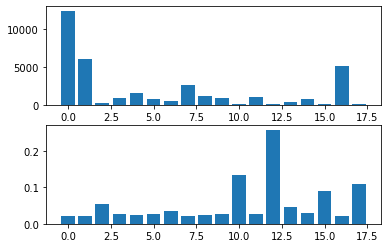

In [7]:
# Check class distribution
plt.subplot(211)
x_axis = range(len(y[0]))
plt.bar(x_axis,np.sum(y,axis=0))
plt.subplot(212)
k = 300; # K-ORIGINAL
soft = lambda x: np.exp(k*x)/np.sum(np.exp(k*x))
importance_w = soft(1/np.sum(y, axis=0));
plt.bar(x_axis,importance_w);

y_map = np.eye(len(y[0]))
importance_vector = [np.dot(i,importance_w) for i in y]

In [8]:

perc_test = .1;
# Conjunto de test estratificado.
#X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X, y, 
#                               test_size = perc_test, 
#                                random_state = 1492, 
#                                shuffle = True,
#                               );

i_train_split, i_test_split= train_test_split(range(len(y)),
                               test_size = perc_test, 
                               random_state = 1492, 
                               shuffle = True,
                               );

X_train_split = [X[i] for i in i_train_split];
y_train_split = [y[i] for i in i_train_split];
importance_train_split = [importance_vector[i] for i in i_train_split];

X_test_split = [X[i] for i in i_test_split];
y_test_split = [y[i] for i in i_test_split];
importance_test_split = [importance_vector[i] for i in i_test_split];




n_train_total = 0;
n_test_total = 0;

n_train = np.sum(y_train_split, axis = 0)
n_test = np.sum(y_test_split, axis=0)
n_train_dual = np.sum([np.sum(i) > 1 for i in y_train_split])
n_test_dual = np.sum([np.sum(i) > 1 for i in y_test_split])

n_cl10 = len([i for i in y_train_split if (i[0] == 1) & (i[1] == 0)])
n_cl11 = len([i for i in y_train_split if (i[0] == 1) & (i[1] == 1)])
n_cl01 = len([i for i in y_train_split if (i[0] == 0) & (i[1] == 1)])

print('Class 10. Train:{0}'.format(n_cl10))
print('Class 01. Train:{0}'.format(n_cl01))
print('Class 11. Train:{0}'.format(n_cl11))


Class 10. Train:10792
Class 01. Train:5060
Class 11. Train:399


# Preparing data for training
In the cell below the generator that reads every feature file is depicted. It essentialy reads random batches of files, which are prepared to be fed into a neural network. Consider that the structure of the models proposed here is: `(batch_elements, time_index, freq_index)`.

In [9]:
'''
If using generators is the preferred option, this code will produce a generator function 
that will be used afterwards by the fit_generator function.
'''
            
def generate_arrays_from_file(h5_file, x_list, y_list, batch_size):
    seed = 1492;
    while True:
        random.seed(seed)
        data_list = [(i,j) for i,j in zip(x_list, y_list)];
        data_list_rand = random.sample(data_list,len(data_list));
        for i in np.arange(0,len(data_list_rand),batch_size):
            x_aux = [np.expand_dims(h5_file[data_list_rand[j][0]+'-spec'],axis=2) for j in np.arange(i, np.min([i+batch_size, len(data_list_rand)]))]
            x_aux = np.concatenate(x_aux, axis=2)
            
            y_aux = [np.expand_dims(data_list_rand[j][1],axis=2) for j in np.arange(i, np.min([i+batch_size, len(data_list_rand)]))]
            y_aux = np.concatenate(y_aux, axis = 1)
            

            x = np.transpose(x_aux, [2,1,0])
            y = np.transpose(y_aux, [1,0]);
            try:
                yield (x,y)
            except StopIteration:
                return    
        seed+=100;
# hf = h5py.File(h5_path, 'r')
# x_batch, y_batch = generate_arrays_from_file(hf, X_train_split, y_train_split,4)



def time_decay(epoch, lr):
    if epoch == 10000:
        return lr/10;
    elif epoch == 10000:
        return lr/10;
    else:
        return lr

Here I show the structure that was proposed originally for the project, although further progress might have been done in the last years.

It is a simple model where 1D-convolutional layers with identity connections are connected (two blocks), considering that each element is batch-normalized in order accelerate training. Notice as well that Dropout is included in order to help with regularization, since for this first approach a relatively small number of audio files has been used (near 10000 files). Different blocks are connected using maxpooling, and in the end the structure is flattened in order to be fed into a 2-layer dense network. The output of this dense network uses two sigmoid units, which should cope with the our multi-label dataset.

I expected this model to be trained with a much bigger number of files, since the Audioset dataset is huge. Consequently, it was originally designed to be magnified considering more residual blocks such as the two depicted in the plot.



In [10]:
# def model_import_custom(ind, n_filters, input_shape,output_shape = 2, n_seed=15000321):
#     from keras.models import Model, load_model
#     from keras.layers import CuDNNGRU, Input, Dense, BatchNormalization, Activation, TimeDistributed
#     import keras.backend as K
#     import numpy as np
#     from keras_attention.models.custom_recurrents import AttentionDecoder
#     from keras.layers.wrappers import Bidirectional
    

#     x_in = Input(shape = (input_shape[0],input_shape[1]), name='in_signal');             
#     x = Bidirectional(CuDNNGRU(n_filters, return_sequences=True, name='encoder'))(x_in)
#     x = BatchNormalization()(x)
#     x_attention = AttentionDecoder(int(n_filters/2), input_shape[1],name='out_main')(x)
        
#     model_CNN = load_model('logs/Gen_CNN_MULTI-2020-05-05_13.27.04.380845/Gen_CNN.h5')
#     # We freeze the weights of the CNN model.
#     for i in model_CNN.layers:
#         i.trainable = False;
#     #x = model_CNN()(x_attention)
#     x = model_CNN(inputs = x_attention)
        
#     model = Model(inputs=x_in, outputs=x)
#     model.summary()


# model_import_custom('Gen_Attention',64, [10,64])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


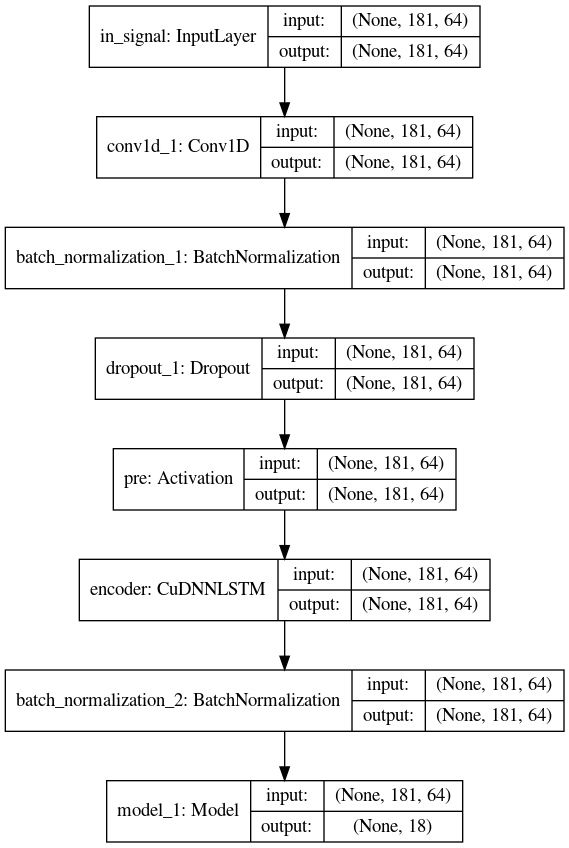

In [11]:
fs = 22050;
t_axis = int(9/hop_length)+1; # Number of temporal frames. Consdier that we keep only 9 seconds of audio for each file.
input_shape = (t_axis, n_mel);

model_name = 'Pre_feature_singleLSTM_BIG'
from Audioset_models import model_import
plot_model(model_import(model_name,64, input_shape,output_shape=17),show_shapes=True, show_layer_names=True, to_file='{}_MULTI.png'.format(model_name))
from IPython.display import Image
Image(retina=True, filename='{}_MULTI.png'.format(model_name))

# Training

Here is the code for training a model.The structure allows to select between different models, which shall be stored int he file `Audioset_models.py`. These models are selected using the `ind_mod` variable, which allows to program this notebook so we can train several models in a consecutive way. However, this has not been necessary yet so there are improvements that need to be implemented here.

With `epoch_init` the code is initialized for the first epoch, which means that several aspects are created:
* The model is created and compiled.
* Learning rate is adjusted.
* The folder to store the Tensorboard outcome and metadata is created.
* Callbacks for themodel are initialized.

Afterwards, the model is trained using a generator that reads batches of random feature files. Once the model is trained, it is stored as well as its metadata for further analysis.

Notice that this implementation is programmed so it works when we stop the model and restart at the same epoch.

The model is supposed to be trained  using Adam during a significant number of epochs. The batch size should be adjusted in order to minimize strong deviations in the loss-curve. The selected loss is `binary_crossentropy`, which shall compliment the two output sigmoid units.

In [ ]:
n_units = 64;
n_epochs =600;
epoch_init = 0;
batch_size = 81*3;
n_seed = 1535789;
    
for ind_mod in [5]:#np.arange(1,5):
    if ind_mod == 1:
        model_name = 'Gen_CNN';
        loss_name = 'binary_crossentropy';
        metric_name = 'binary_accuracy';
        lr = .01;
        clipping = False;
        optimizer = Adam(lr = lr) # lr=0.001
    if ind_mod == 2:
        model_name = 'Gen_Attention';
        loss_name = 'binary_crossentropy';
        metric_name = 'binary_accuracy';
        lr = .1;
        clipping = .1;
        optimizer = SGD(lr = lr,clipnorm=clipping) # lr=0.001
    if ind_mod == 3:
        model_name = 'Gen_CNN_small';
        loss_name = 'binary_crossentropy';
        metric_name = 'binary_accuracy';
        lr = .01;
        clipping = False;
        optimizer = Adam(lr = lr) # lr=0.001
    if ind_mod == 4:
        model_name = 'Gen_Attention_BIG';
        loss_name = 'binary_crossentropy';
        metric_name = 'binary_accuracy';
        lr = .1;
        clipping = .1;
        optimizer = SGD(lr = lr,clipnorm=clipping) # lr=0.001
    if ind_mod == 5:      
        model_name = 'Gen_Attention_raw';
        loss_name = 'binary_crossentropy';
        metric_name = 'binary_accuracy';
        lr = .1;
        clipping = .1;
        optimizer = SGD(lr = lr,clipnorm=clipping) # lr=0.001
        reg_l1 = 0.1
    if ind_mod == 6:      
        model_name = 'Pre_feature_singleLSTM_BIG';
        loss_name = 'binary_crossentropy';
        metric_name = 'binary_accuracy';
        lr = .1;
        clipping = .1;
        optimizer = SGD(lr = lr,clipnorm=clipping) # lr=0.001
        reg_l1 = 0.1
    
    
        
    if epoch_init == 0:
        model = model_import(model_name, n_units, input_shape,output_shape = len(y[0]), n_seed=n_seed)    
        
        
        model.compile(loss=loss_name, optimizer=optimizer, metrics=[metric_name])
        tb_base = model_name+'_MULTI-'+str(datetime.datetime.now()).replace(' ','_').replace(':','.');
        os.mkdir(os.path.join('logs',tb_base))

        checkpoint = ModelCheckpoint(os.path.join('./logs',tb_base,'CkPoint.h5'), monitor='val_loss', verbose=1, save_best_only=True, mode='min')

        lrate = LearningRateScheduler(time_decay,verbose=1)
        
        
    h = model.fit_generator(generate_arrays_from_file(hf, X_train_split, y_train_split, batch_size),
                        steps_per_epoch = len(X_train_split)/batch_size,
                        epochs = n_epochs,
                        validation_data = generate_arrays_from_file(hf, X_test_split, y_test_split, batch_size),
                        validation_steps = len(X_test_split)/batch_size,
                        callbacks=[TensorBoard(log_dir=os.path.join('./logs',tb_base)),
                                   checkpoint,
                                   lrate
                                  ],
                        initial_epoch = epoch_init,
                        verbose = 0,
                        class_weight = importance_w
                       )


    model.save(os.path.join('logs',tb_base,model_name+'.h5'))



    metadata = [{'model_name': model_name,
            'n_epochs': n_epochs,
            'batch_size': batch_size,
            'optimizer': optimizer,
            'opt_lr': lr,
            'n_mel': n_mel,
            'n_units': n_units,
            'K': k,
            'clipnorm':clipping,
             'reg_l1': reg_l1
                }]

    csv_file = os.path.join('logs',tb_base,'metadata.csv')
    import csv
    with open(csv_file, 'w') as csvdoc:    
        writer = csv.DictWriter(csvdoc, fieldnames=metadata[0].keys())
        writer.writeheader()
        for i in metadata:
            print(i)
            writer.writerow(i)

/run/media/arodriguez/BIG/anaconda2/envs/deep_py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()



Epoch 00001: LearningRateScheduler reducing learning rate to 0.10000000149011612.

Epoch 00001: val_loss improved from inf to 37373.51167, saving model to ./logs/Gen_Attention_raw_MULTI-2020-05-10_12.08.47.738200/CkPoint.h5

Epoch 00002: LearningRateScheduler reducing learning rate to 0.10000000149011612.

Epoch 00002: val_loss improved from 37373.51167 to 26267.63273, saving model to ./logs/Gen_Attention_raw_MULTI-2020-05-10_12.08.47.738200/CkPoint.h5

Epoch 00003: LearningRateScheduler reducing learning rate to 0.10000000149011612.

Epoch 00003: val_loss improved from 26267.63273 to 19193.28805, saving model to ./logs/Gen_Attention_raw_MULTI-2020-05-10_12.08.47.738200/CkPoint.h5

Epoch 00004: LearningRateScheduler reducing learning rate to 0.10000000149011612.

Epoch 00004: val_loss improved from 19193.28805 to 14602.54737, saving model to ./logs/Gen_Attention_raw_MULTI-2020-05-10_12.08.47.738200/CkPoint.h5

Epoch 00005: LearningRateScheduler reducing learning rate to 0.100000001490

In [ ]:
model.layers[1].get_weights()

In [ ]:
#y_pred = model.predict_generator(generate_arrays_from_file(hf, X_test_split, y_test_split, batch_size), steps= len(X_test_split)/batch_size);
X_test_split
j = 1;
x_partial = [np.expand_dims(hf[filename+'-spec'],axis=2) for filename in X_test_split]
x_pred = np.transpose(np.concatenate(x_partial, axis=2), [2,1,0]);
# y_pred = model.predict(x_pred)

from keras.models import Model
model_features = Model(inputs = model.layers[0].input, outputs = model.layers[1].output)

y_features = model_features.predict(x_pred)       

In [ ]:
ind = 16
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(y_features[ind, :,:].T)
plt.colorbar()
plt.subplot(212)
plt.imshow(x_pred[ind,:,:].T)
plt.colorbar()
x_pred.shape

In [ ]:
from sklearn.metrics import roc_auc_score
roc_results = {};
y_true = np.array(y_test_split);
for i_class in range(y_pred.shape[1]):
    roc_results[i_class] = roc_auc_score(y_true[:,i_class], y_pred[:,i_class])
    
roc_results

In [ ]:
plt.subplot(311)
x_axis = range(len(y[0]))
plt.bar(x_axis,np.sum(y,axis=0))
plt.subplot(312)
plt.bar(x_axis,importance_w);
plt.subplot(313)
plt.bar(x_axis,roc_results.values())
plt.ylim([.74,1])

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(h.history['val_loss'], label='test',linewidth=3)
plt.plot(h.history['loss'], label='train',linewidth=3)
plt.title('Binary cross-entropy');
plt.grid()
plt.legend()

plt.subplot(212)
plt.plot(h.history['val_binary_accuracy'], label='test',linewidth=3)
plt.plot(h.history['binary_accuracy'], label='train',linewidth=3)
plt.title('Accuracy')
plt.grid();
plt.legend();